In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot

In [2]:
def length_to_windows(length_df, pops, window_size=100000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")

In [4]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen200/tanzania_focus/"

In [5]:
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

In [6]:
north_south_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    north_south_mapping[o_order[o]] = o

In [7]:
north_south_mapping

{'Hamadryas, Ethiopia': 0,
 'Kindae, Zambia': 1,
 'Papio, Senegal': 2,
 'Ursinus, Zambia': 3}

In [8]:
df_l = []
for chrom in ["all_chrX", "female_chrX"]: #list(range(15, 21))+["X"]:
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

In [9]:
window_df_l = []
for chrom in length_df.chrom.unique():
    print(chrom)
    chrom_df = length_df.loc[length_df.chrom == "{}".format(chrom)]
    pops = chrom_df.reference.unique()
    for ind in chrom_df.individual.unique():
        ind_df = chrom_df.loc[chrom_df.individual == ind]
        window_df_ind = length_to_windows(ind_df, pops)
        window_df_ind["chrom"] = "{}".format(chrom)
        window_df_ind["individual"] = ind
        window_df_l.append(window_df_ind)
window_df = pd.concat(window_df_l)

all_chrX
female_chrX


In [10]:
window_df["Origin"] = window_df.individual.map(dict(zip(meta_data_samples.PGDP_ID,
                                                        meta_data_samples.Origin)))
window_df["north"] = window_df["Hamadryas, Ethiopia"]+window_df["Papio, Senegal"]
window_df["norm_north"] = (window_df.north-window_df.iloc[:,1:5].sum(axis=1)/2)
window_df["start"] = window_df["windows"]

In [11]:
window_df.to_csv("../steps/rfmix_v3_chrX_windowed_df.txt", index=False)

Investigation of chrX, later run for autosomal resuls.

In [49]:
female_olives = meta_data_samples.loc[(meta_data_samples.Species== "anubis") & (meta_data_samples.Sex== "F")].PGDP_ID
female_yellows = meta_data_samples.loc[(meta_data_samples.Species== "cynocephalus") & (meta_data_samples.Sex== "F")].PGDP_ID

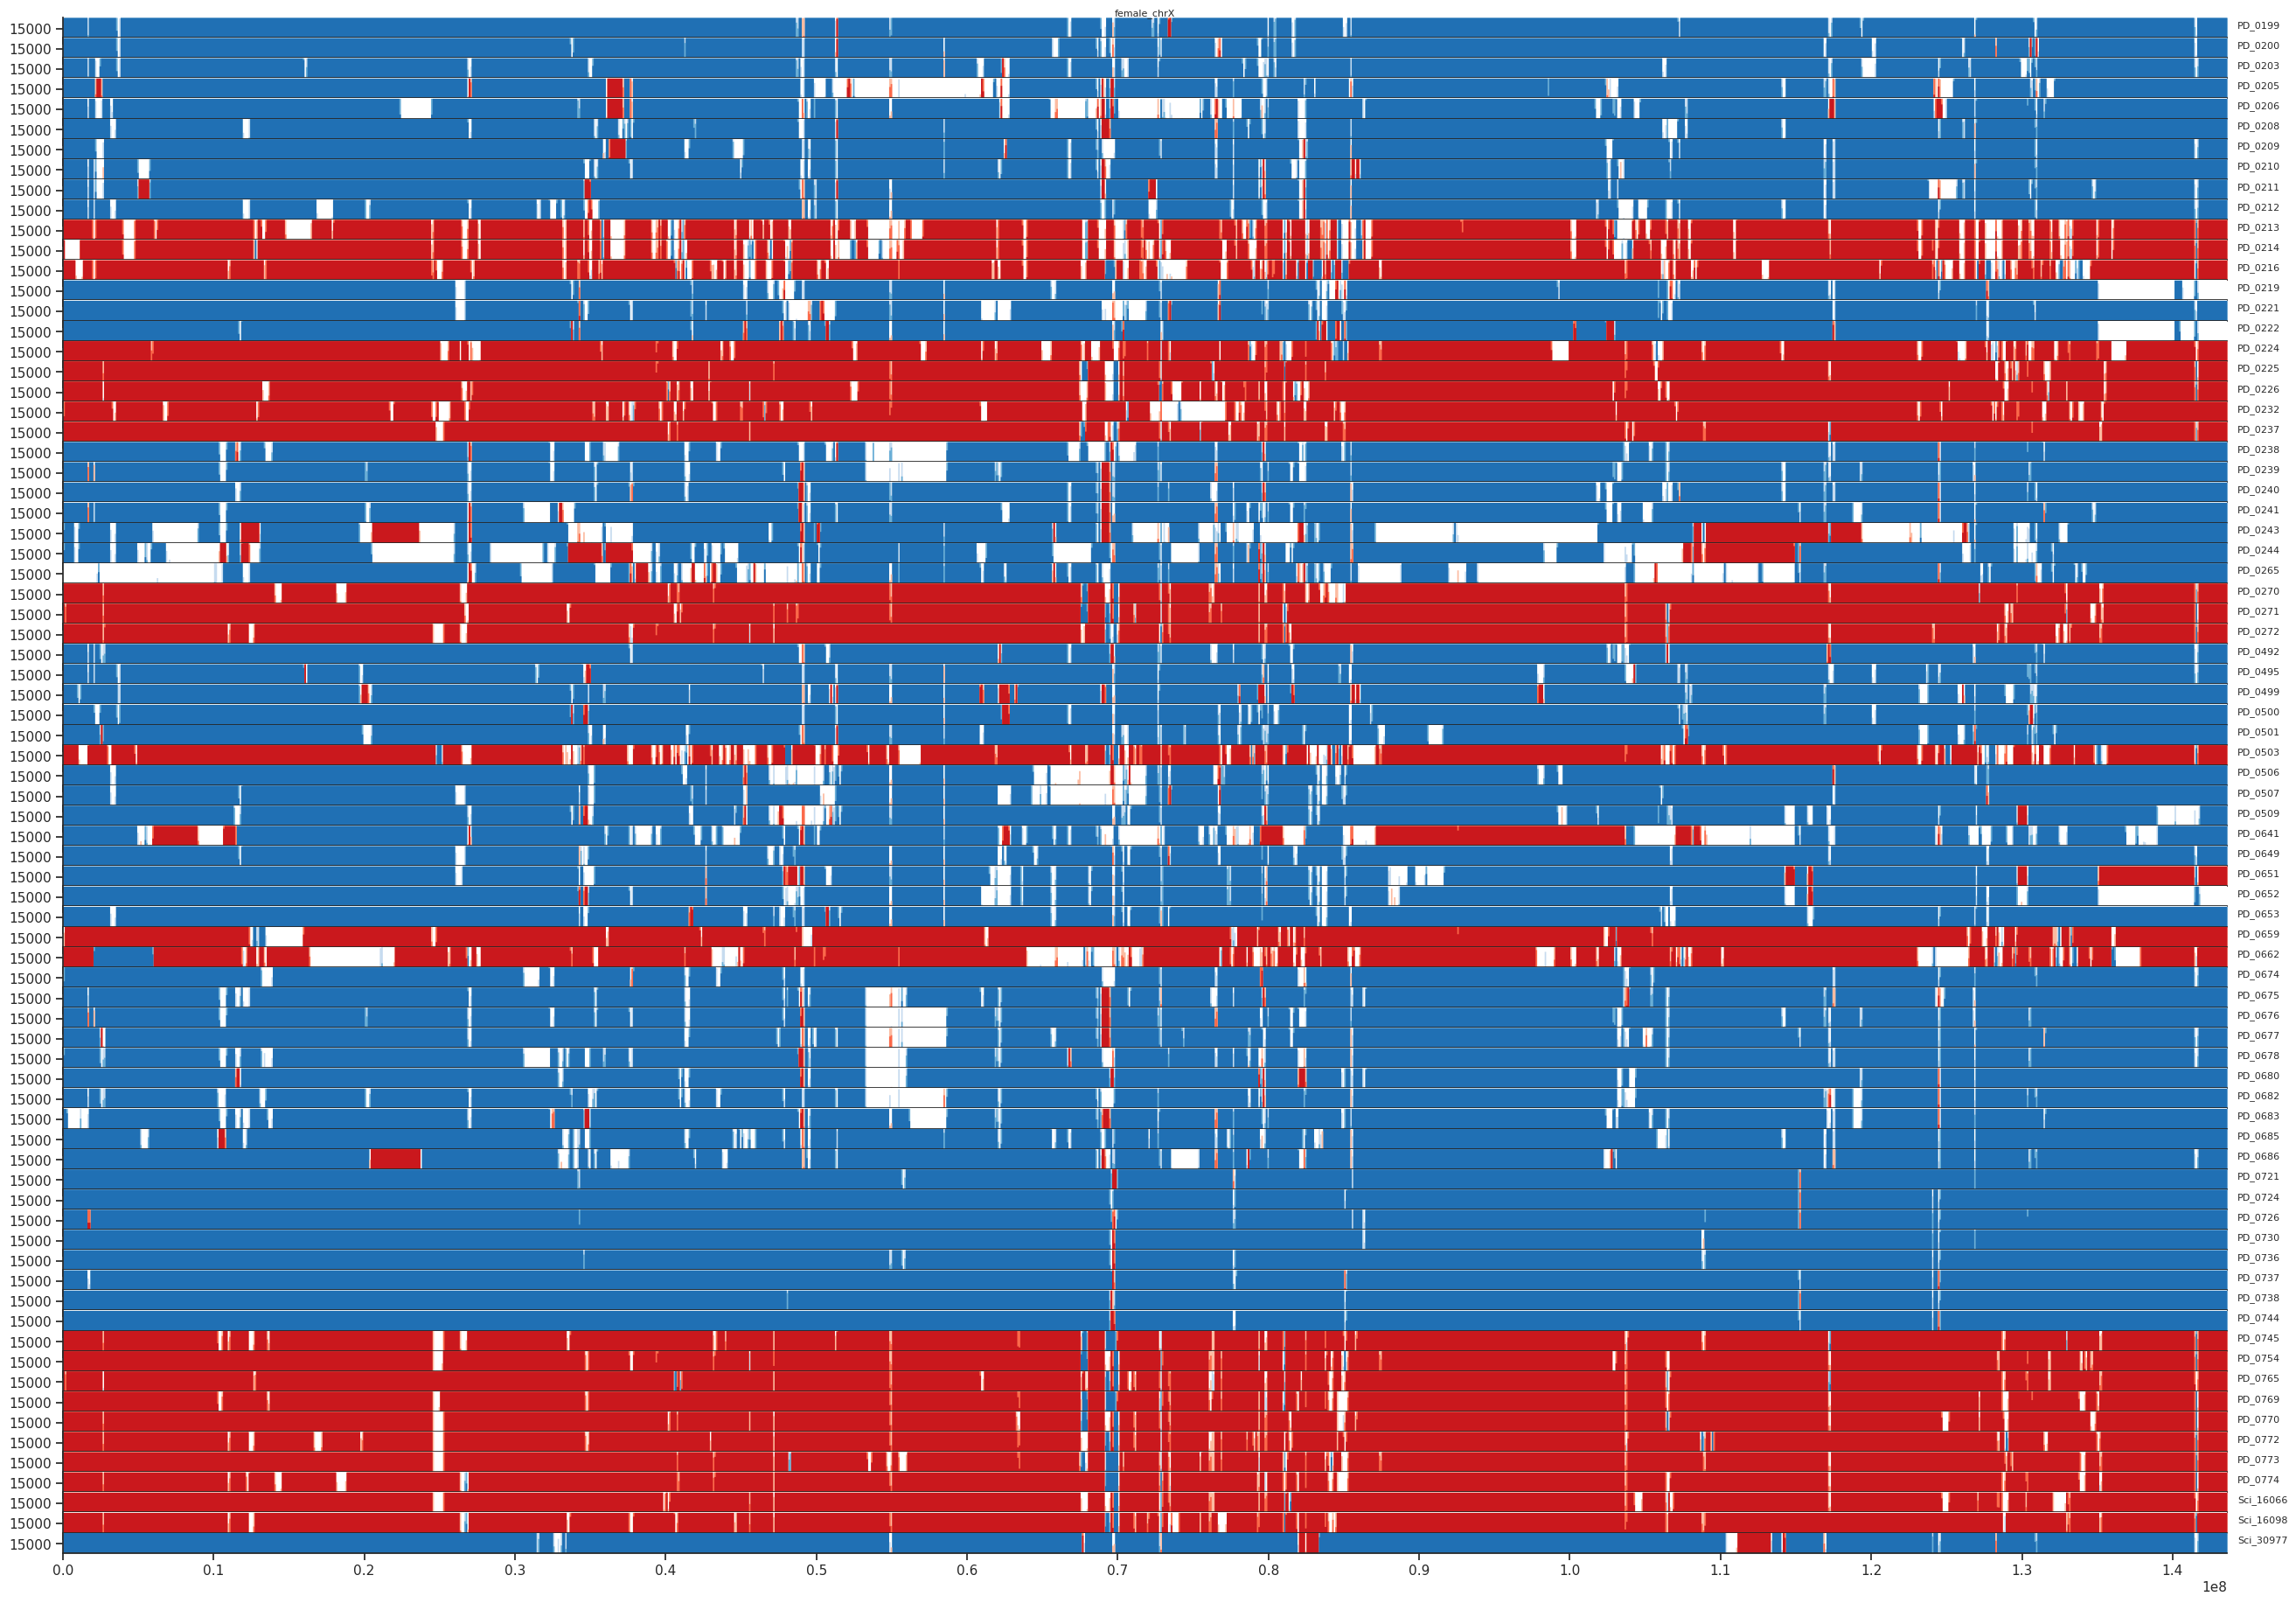

In [32]:
female_chrX = window_df.loc[window_df.chrom == "female_chrX"]
fig = horizonplot(female_chrX, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

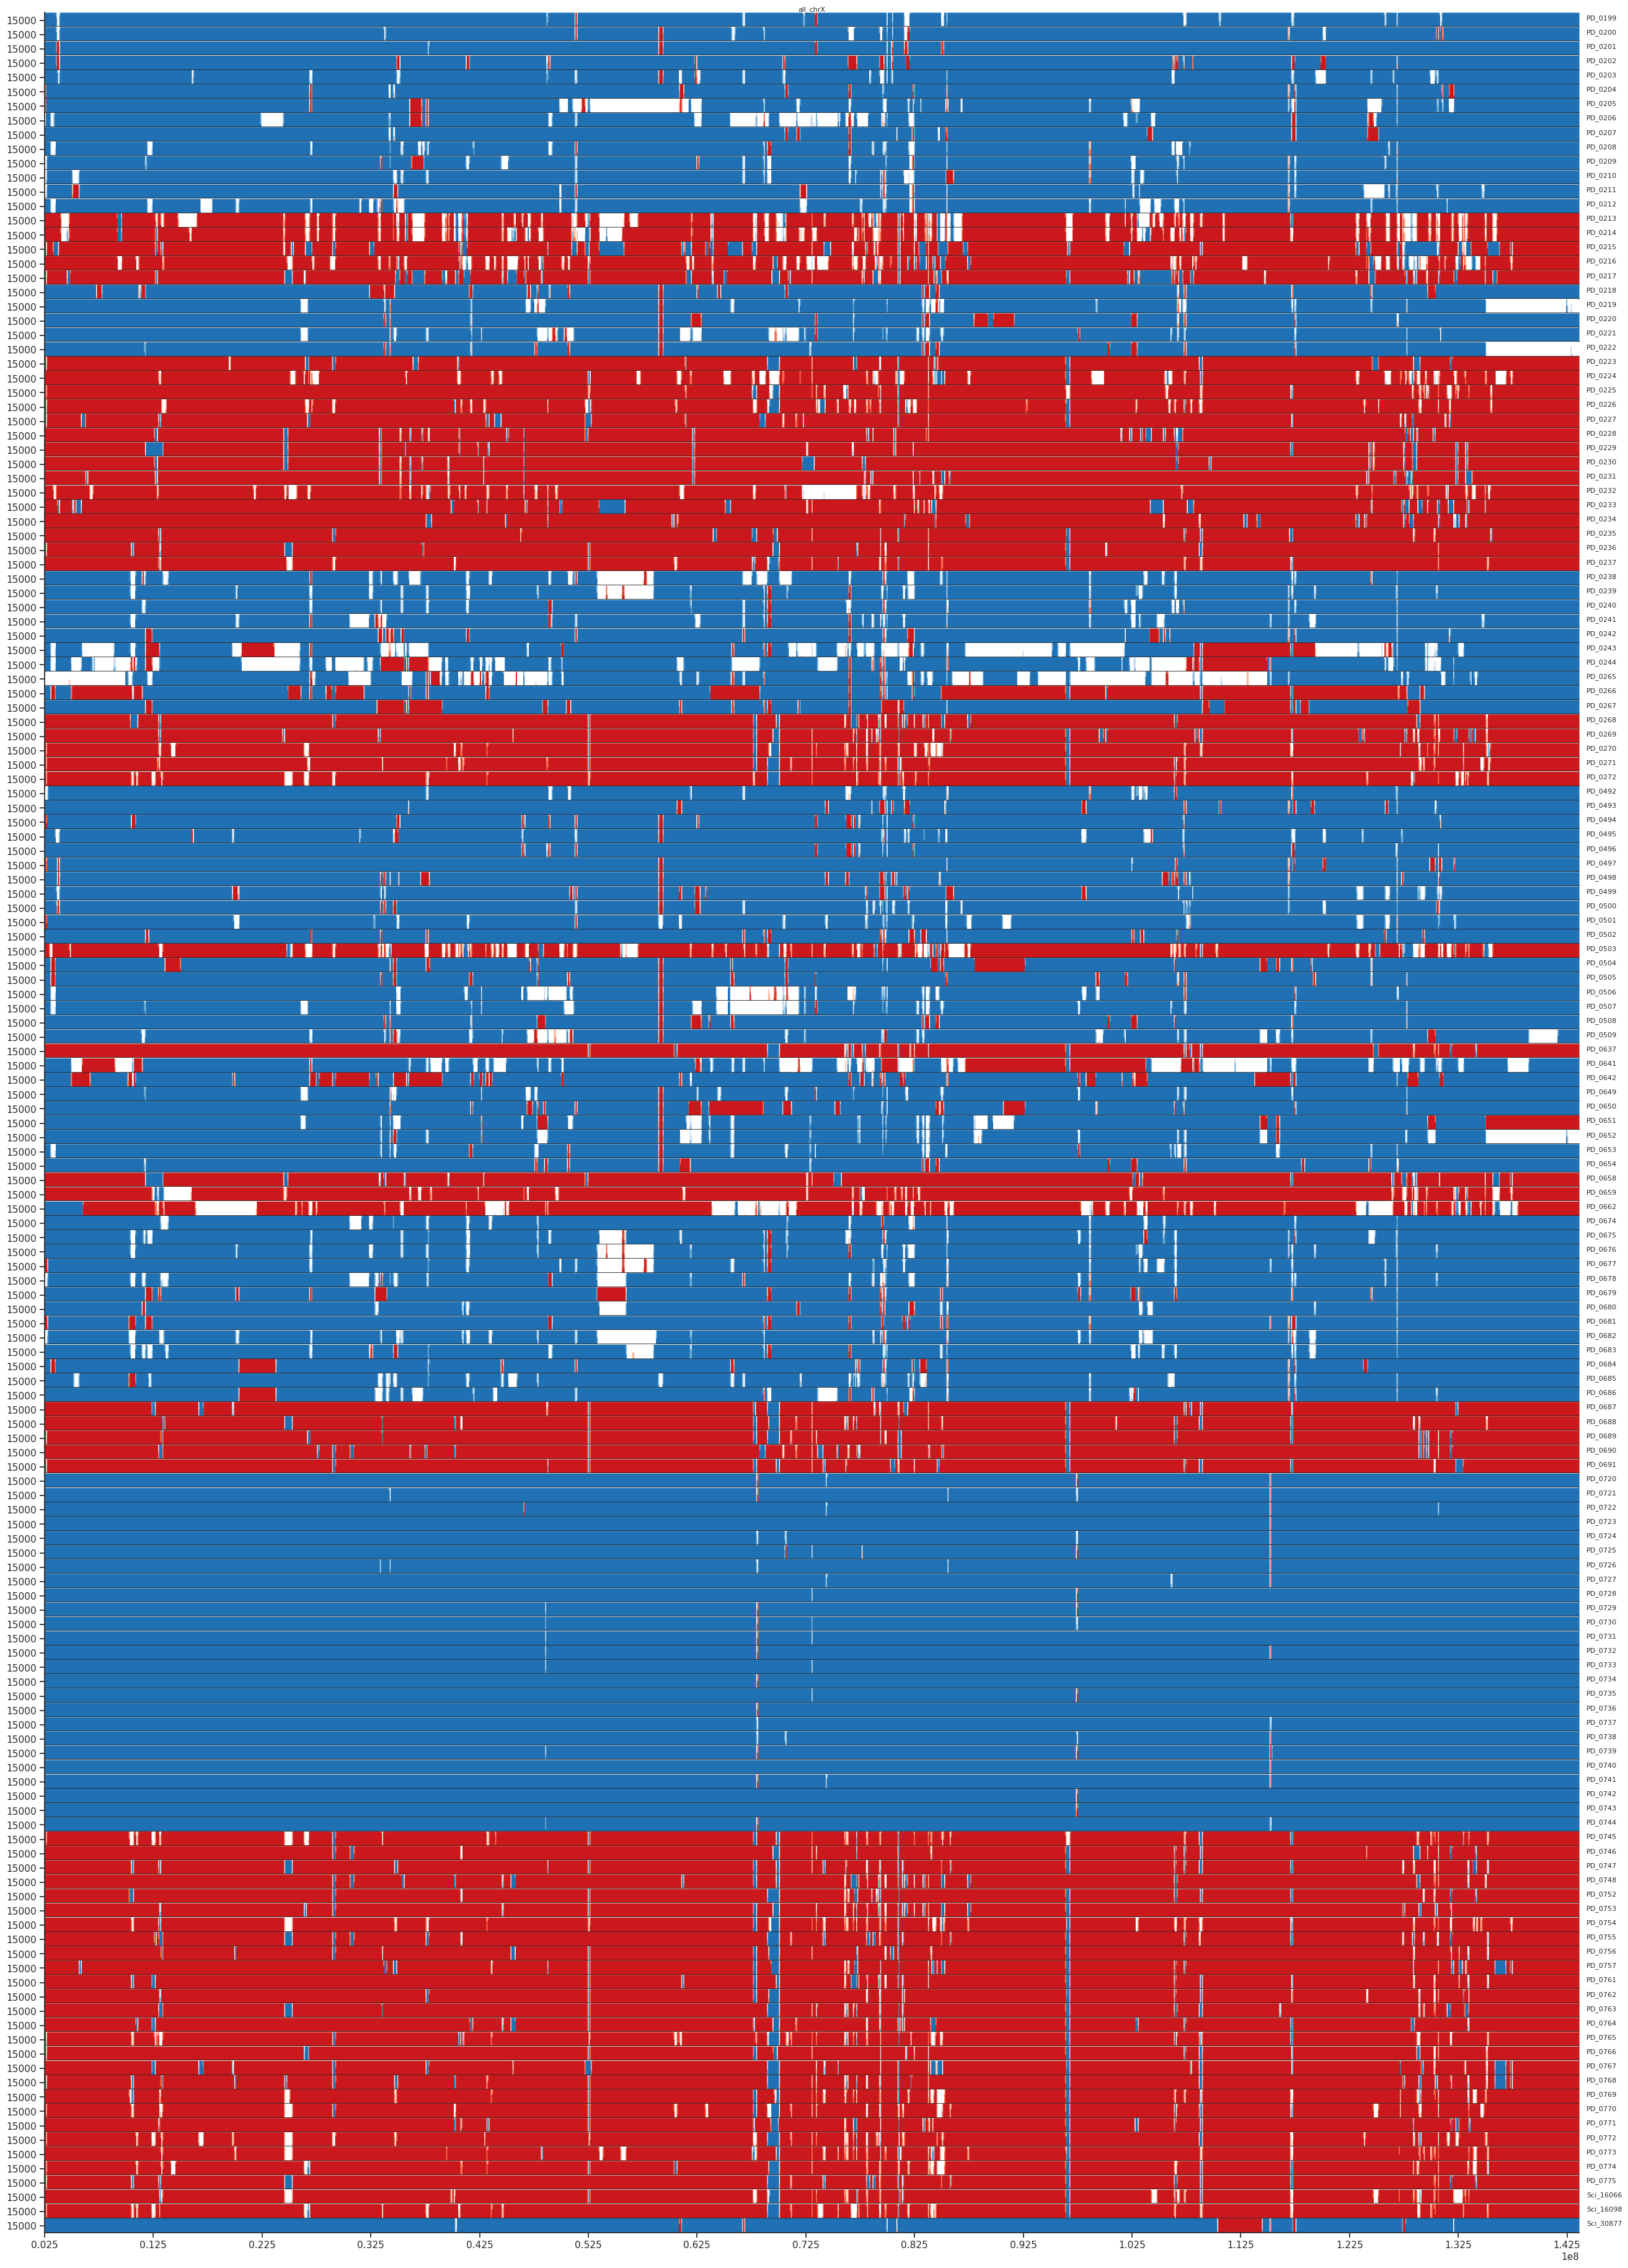

In [33]:
all_chrX = window_df.loc[window_df.chrom == "all_chrX"]
fig = horizonplot(all_chrX, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

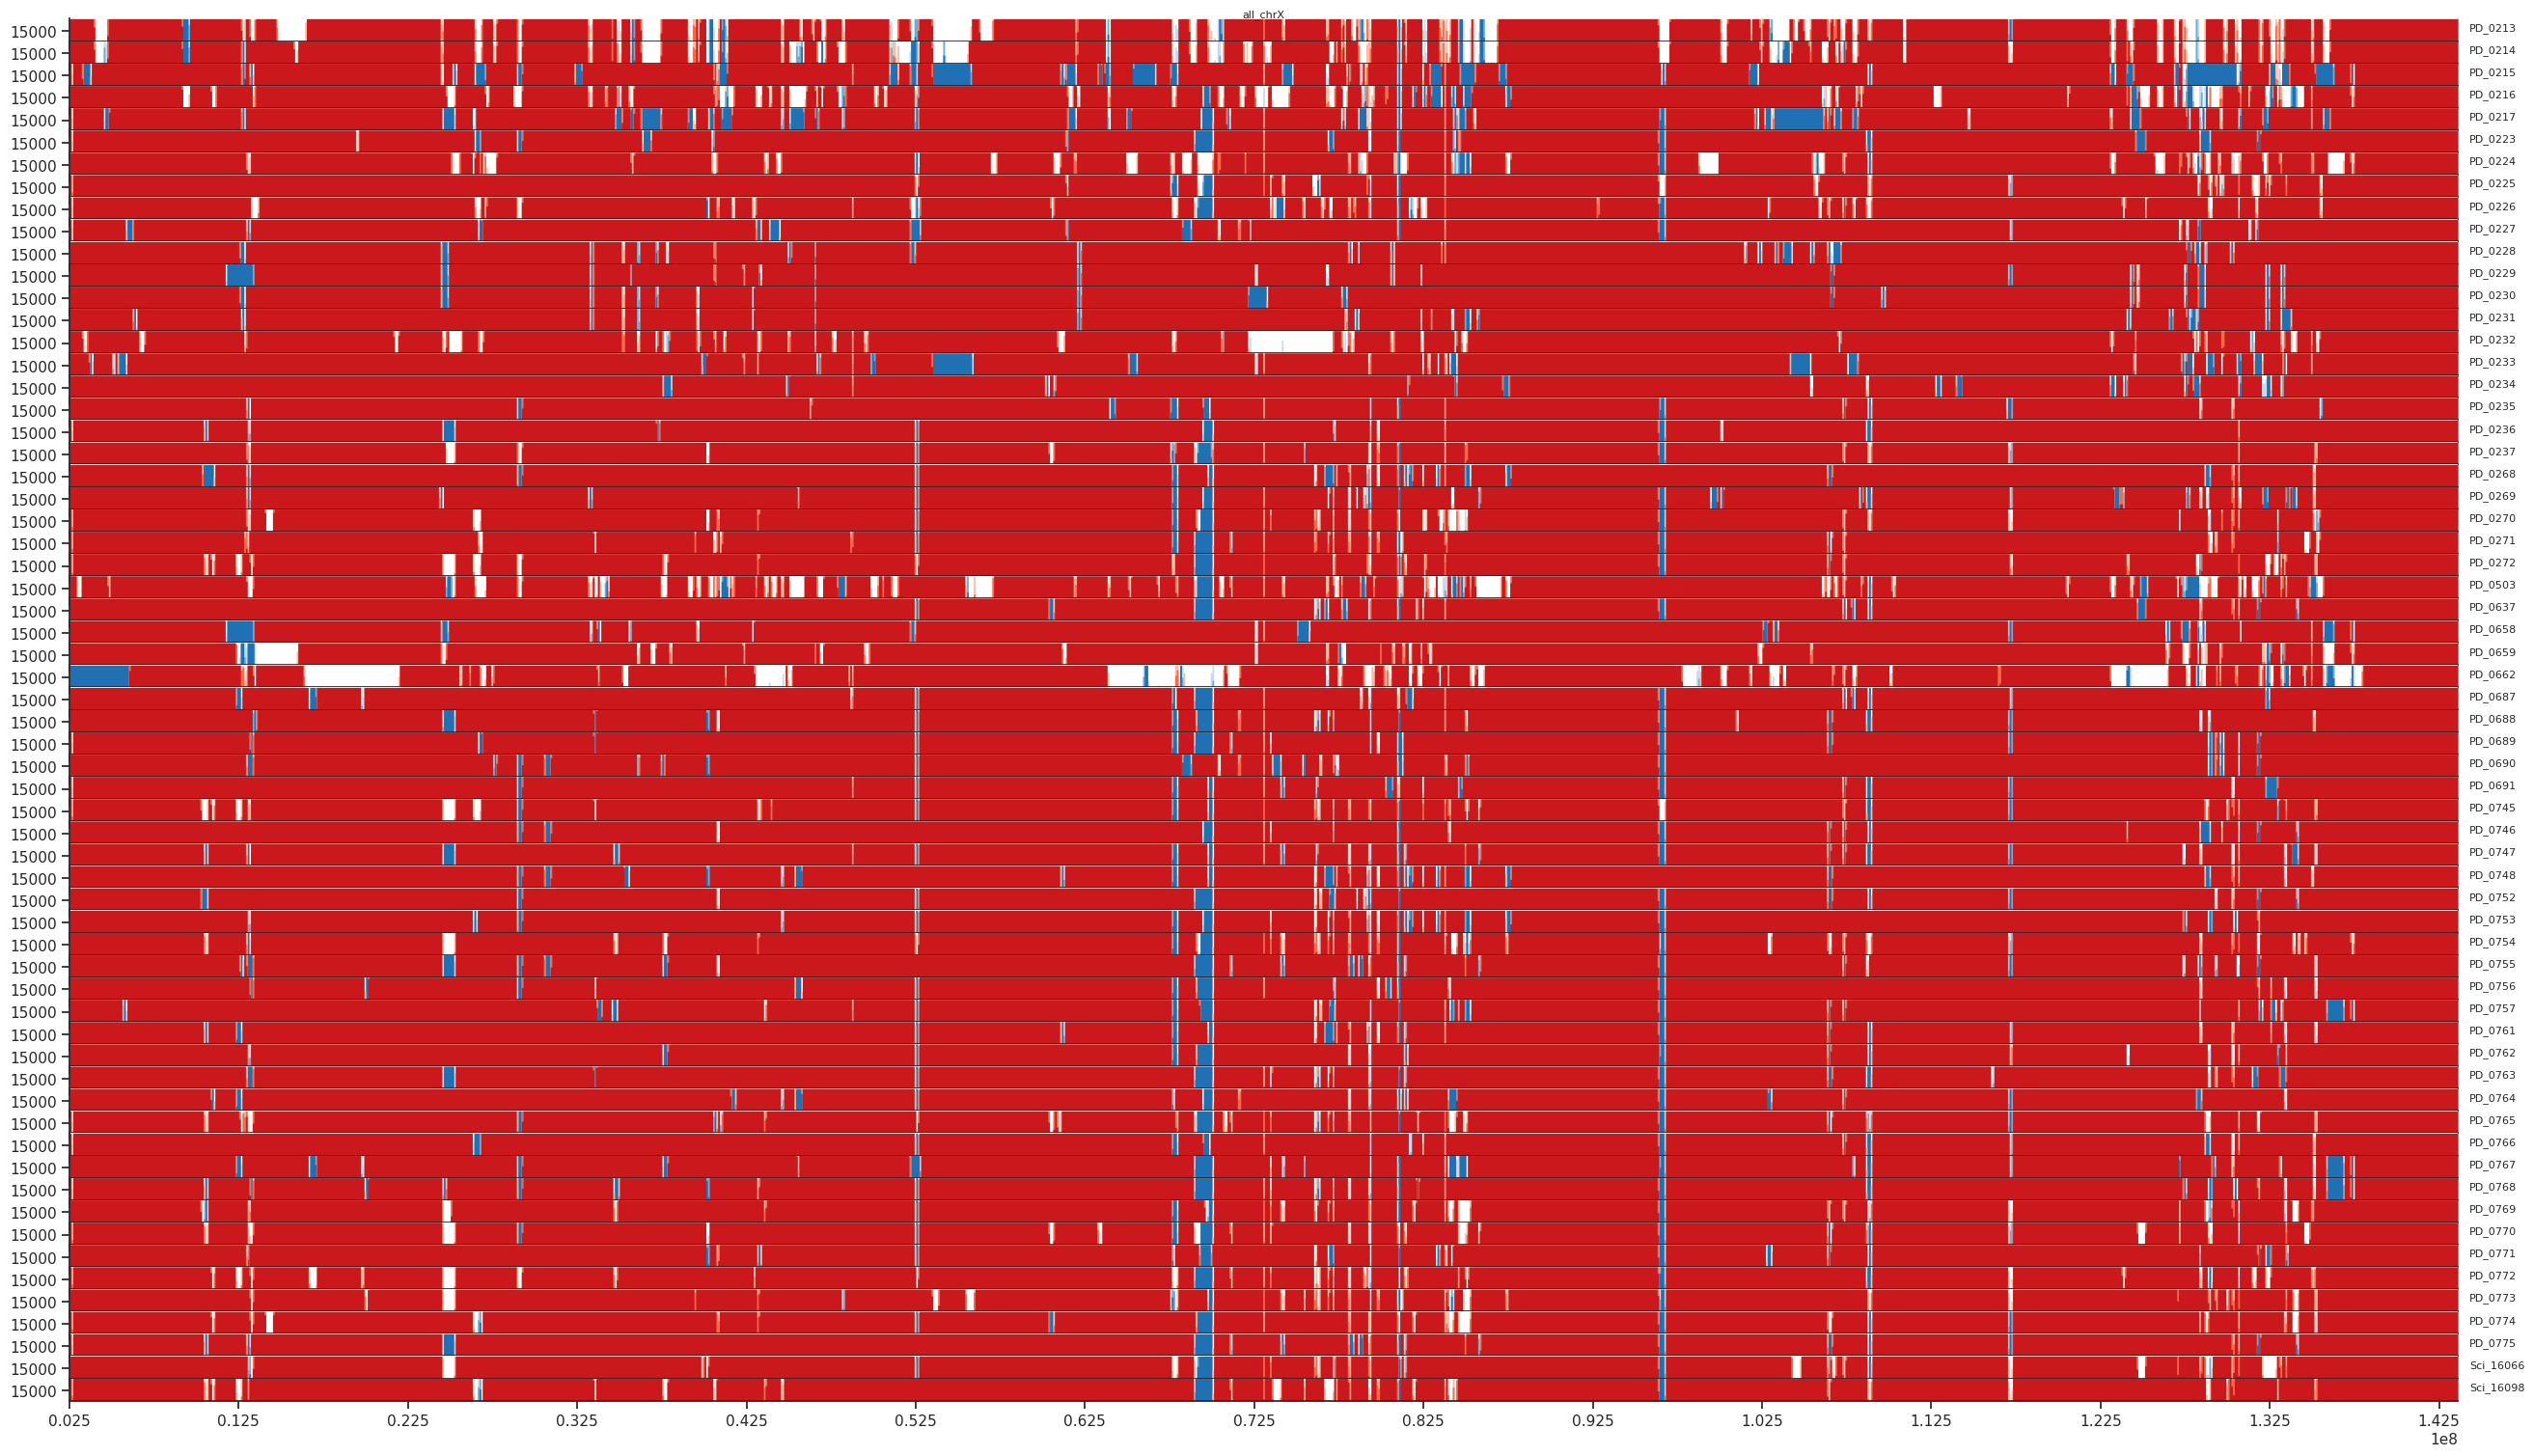

In [57]:
all_chrX = window_df.loc[(window_df.chrom == "all_chrX") &
                         (window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species == "cynocephalus"].PGDP_ID))]
fig = horizonplot(all_chrX, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

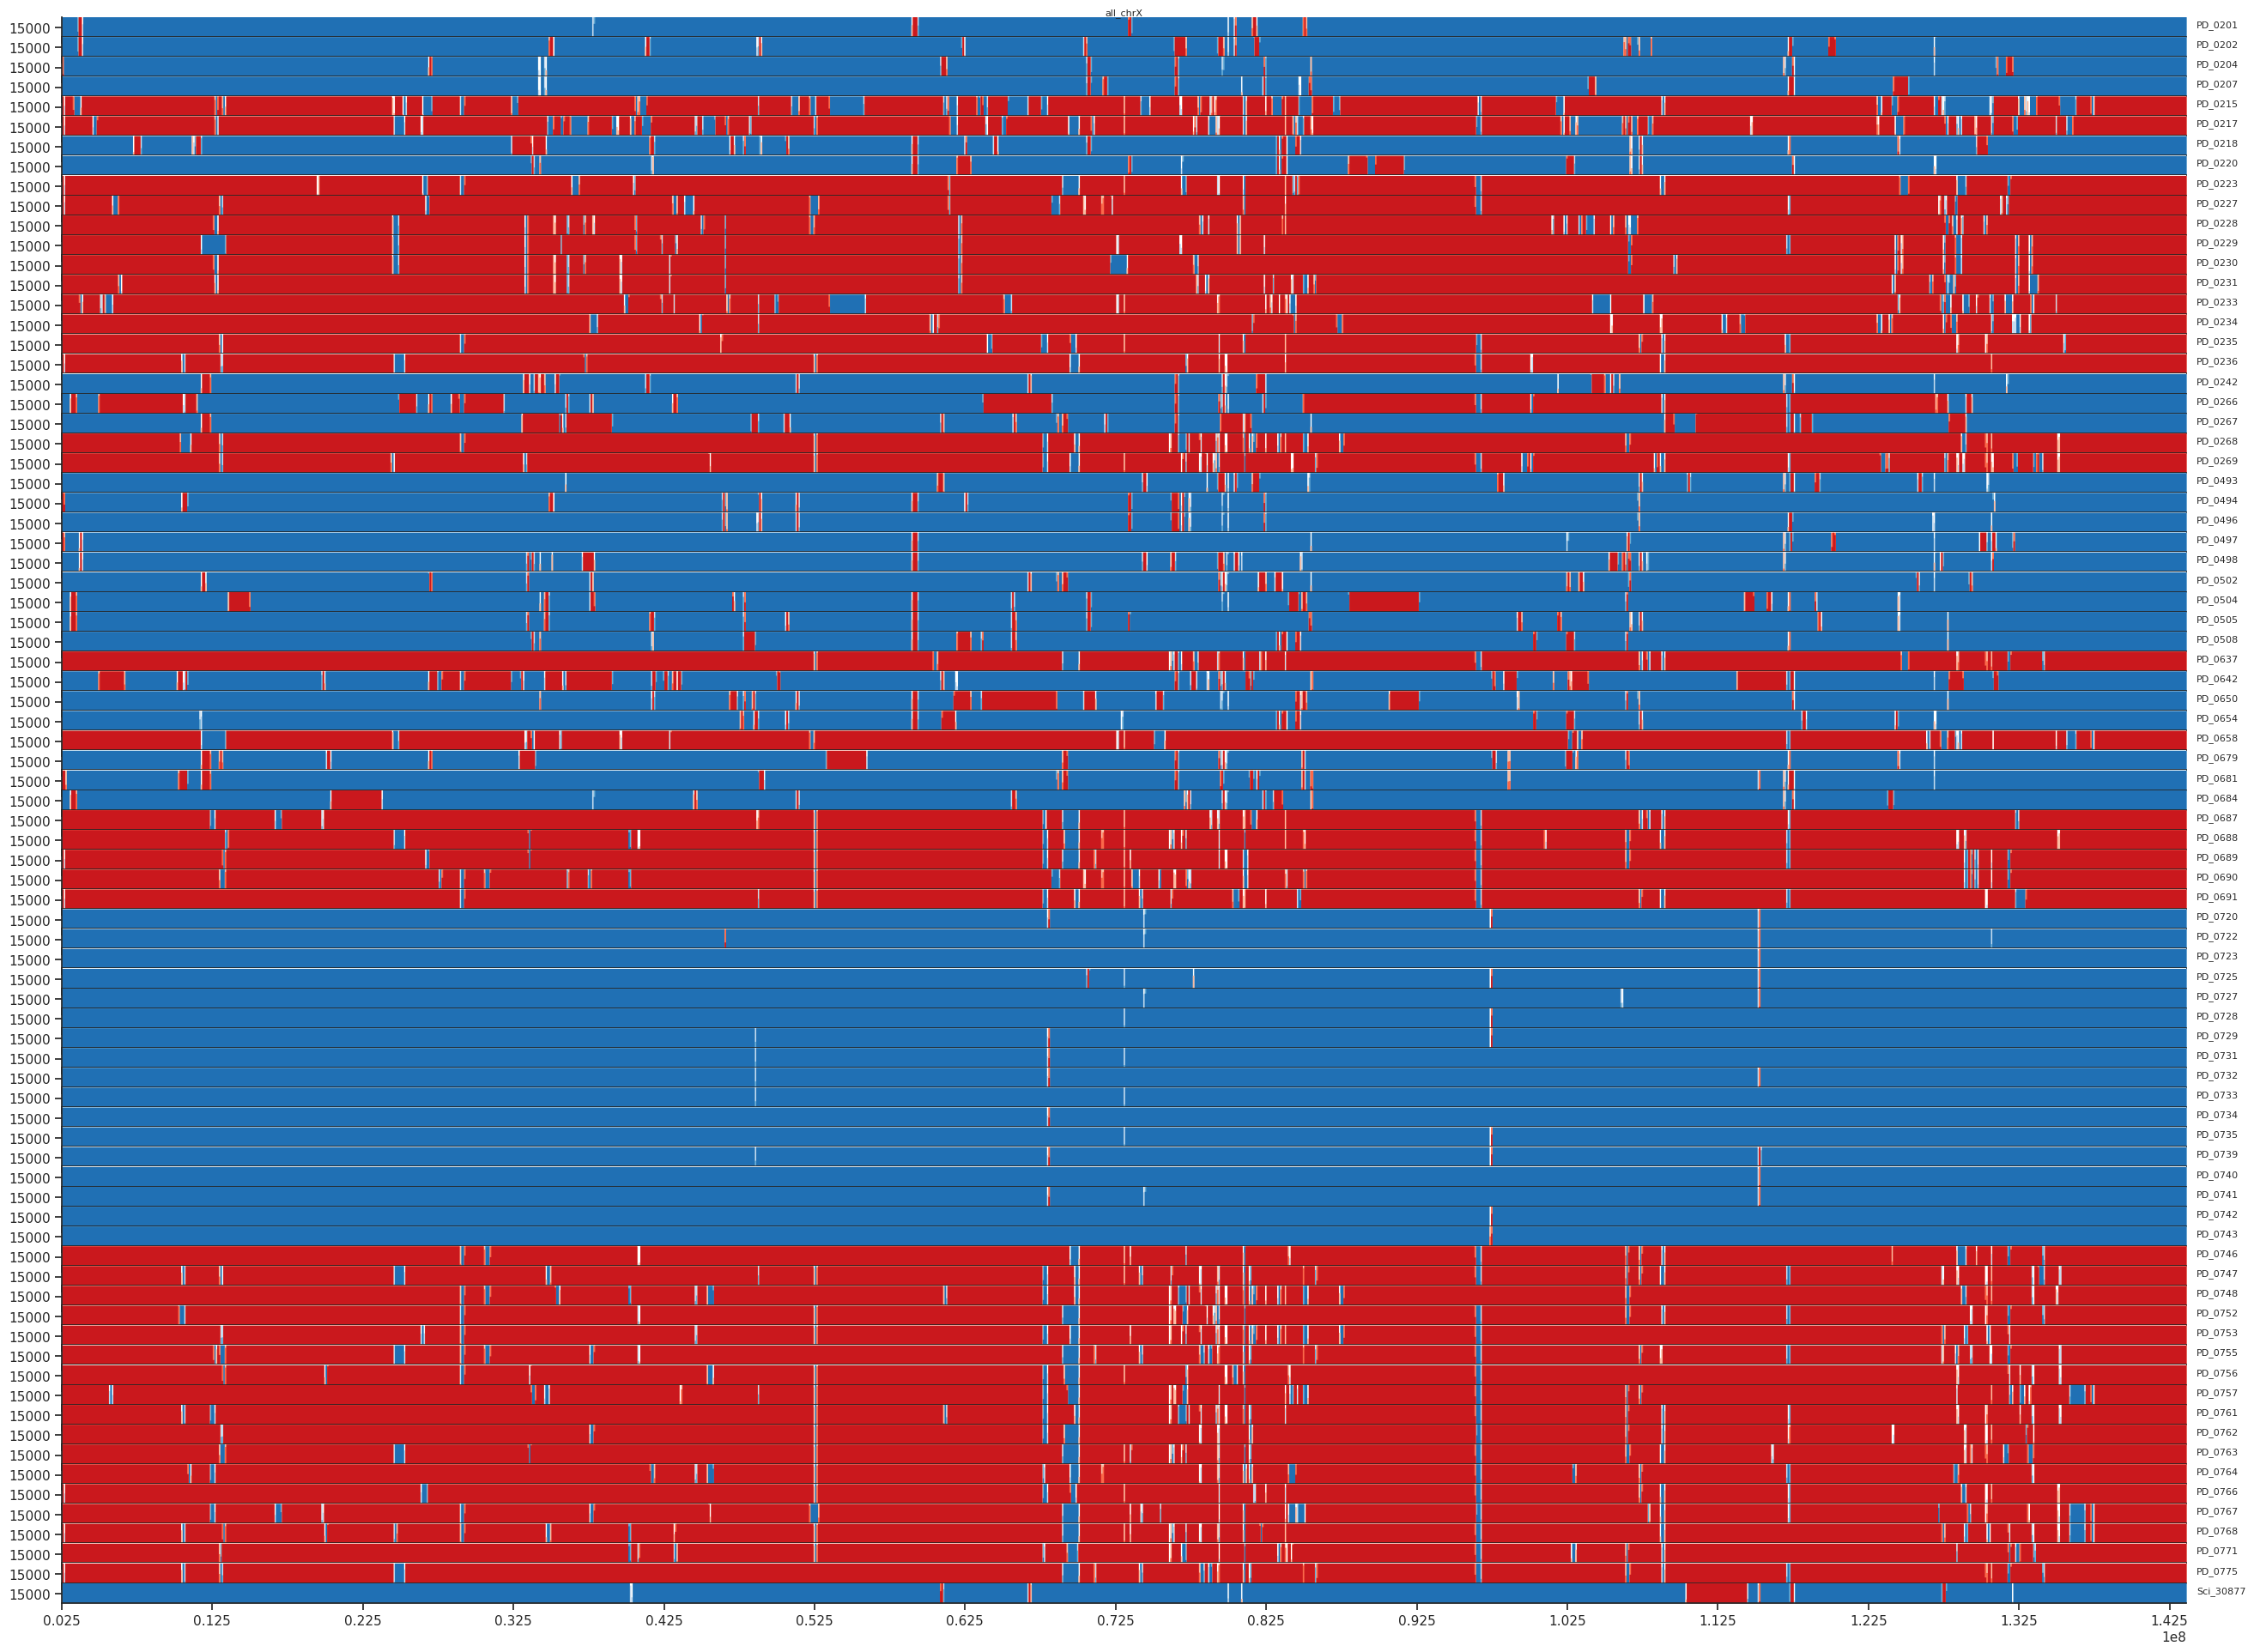

In [44]:
all_chrX = window_df.loc[(window_df.chrom == "all_chrX") &
                         (window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Sex== "M"].PGDP_ID))]
fig = horizonplot(all_chrX, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

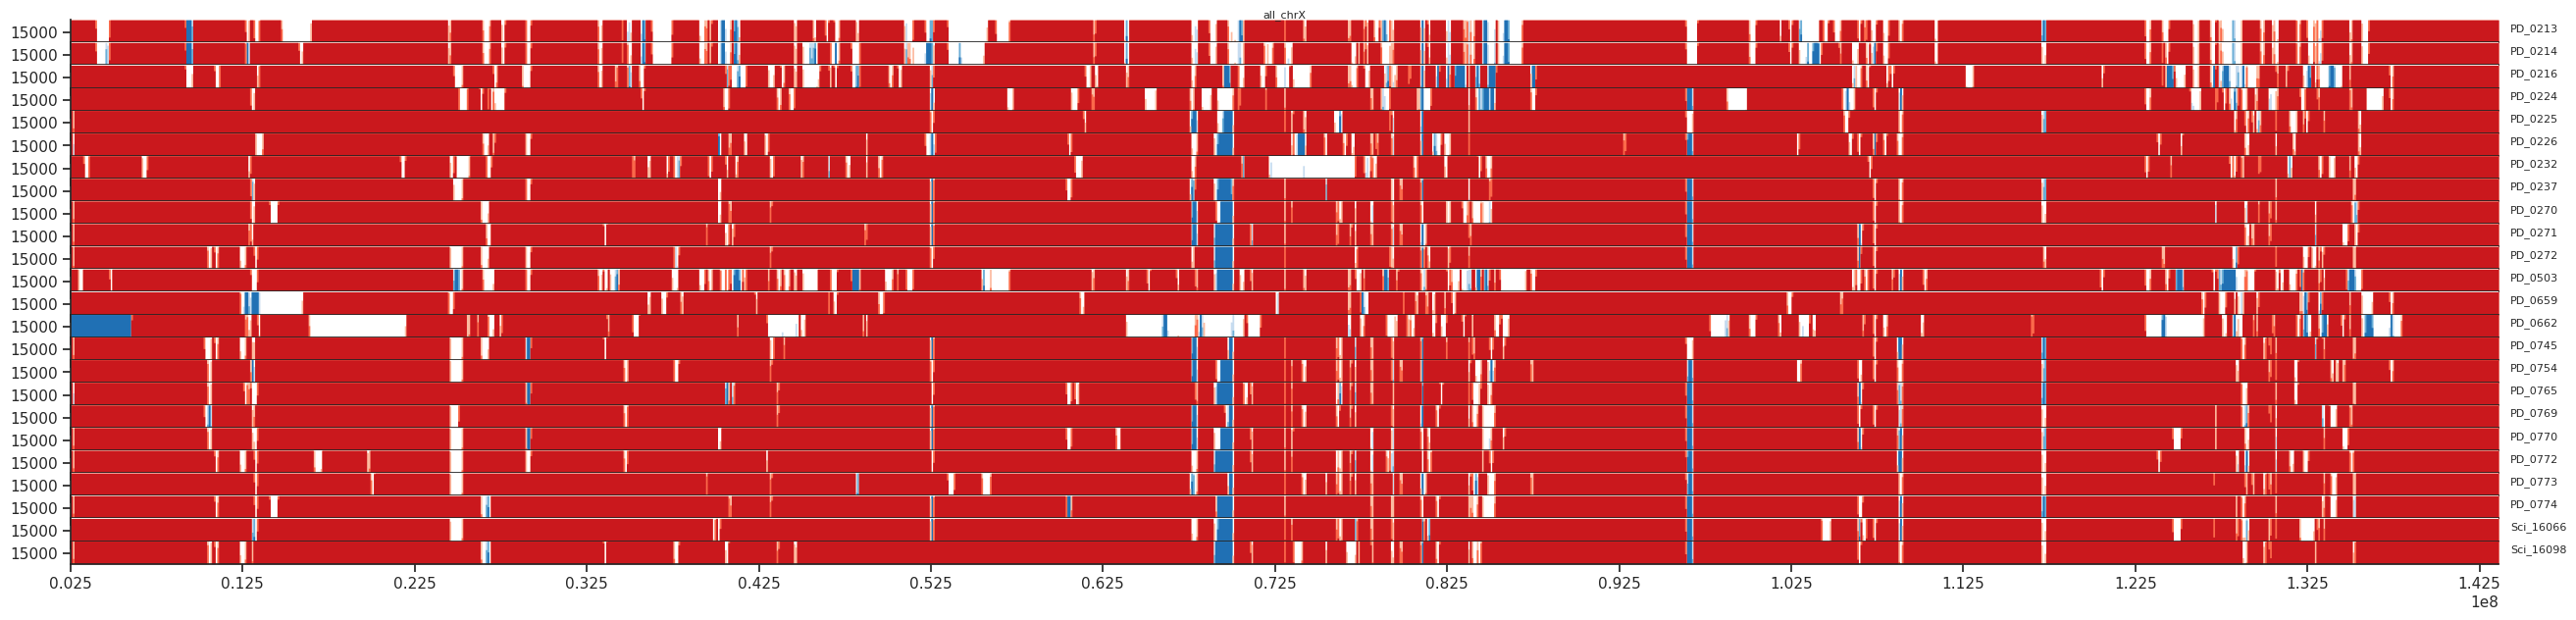

In [51]:
all_chrX = window_df.loc[(window_df.chrom == "all_chrX") &
                         (window_df.individual.isin(female_yellows))]
fig = horizonplot(all_chrX, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

There are some few strecthes which are white, but that is probably due to the windowing process.
In general, results are very comparable across the two versions.

In [53]:
ind_test

windows  Ursinus, Zambia  Kindae, Zambia  Papio, Senegal  \
0       2500194              0.0             0.0             0.0   
1       2600194              0.0             0.0             0.0   
2       2700194              0.0             0.0             0.0   
3       2800194              0.0             0.0             0.0   
4       2900194              0.0             0.0             0.0   
...         ...              ...             ...             ...   
1432  143200037              0.0             0.0        200000.0   
1433  143300037              0.0             0.0        200000.0   
1434  143400037              0.0             0.0        200000.0   
1435  143500037              0.0             0.0        200000.0   
1436  143600037              0.0             0.0        182930.0   

      Hamadryas, Ethiopia        chrom individual               Origin  \
0                200000.0     all_chrX    PD_0641  Tarangire, Tanzania   
1                200000.0     all_chrX    PD_0641  Tarangire, Tanzania   
2                200000.0     all_chrX    PD_0641  Tarangire, Tanzania   
3                200000.0     all_chrX    PD_0641  Tarangire, Tanzania   
4                200000.0     all_chrX    PD_0641  Tarangire, Tanzania   
...                   ...          ...        ...                  ...   
1432                  0.0  female_chrX    PD_0641  Tarangire, Tanzania   
1433                  0.0  female_chrX    PD_0641  Tarangire, Tanzania   
1434                  0.0  female_chrX    PD_0641  Tarangire, Tanzania   
1435                  0.0  female_chrX    PD_0641  Tarangire, Tanzania   
1436                  0.0  female_chrX    PD_0641  Tarangire, Tanzania   

         north  norm_north      start  
0     200000.0    100000.0    2500194  
1     200000.0    100000.0    2600194  
2     200000.0    100000.0    2700194  
3     200000.0    100000.0    2800194  
4     200000.0    100000.0    2900194  
...        ...         ...        ...  
1432  200000.0    100000.0  143200037  
1433  200000.0    100000.0  143300037  
1434  200000.0    100000.0  143400037  
1435  200000.0    100000.0  143500037  
1436  182930.0     91465.0  143600037  

[2849 rows x 11 columns]

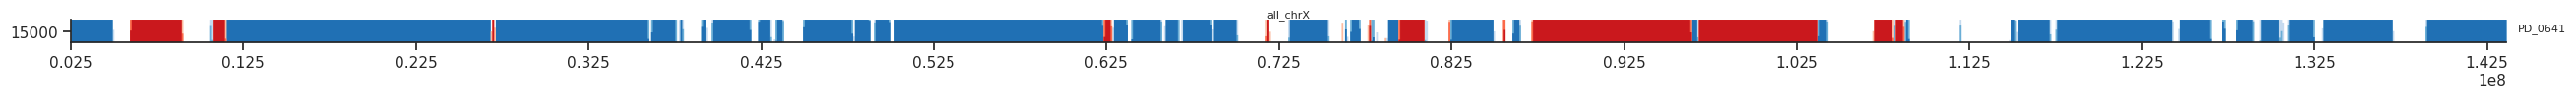

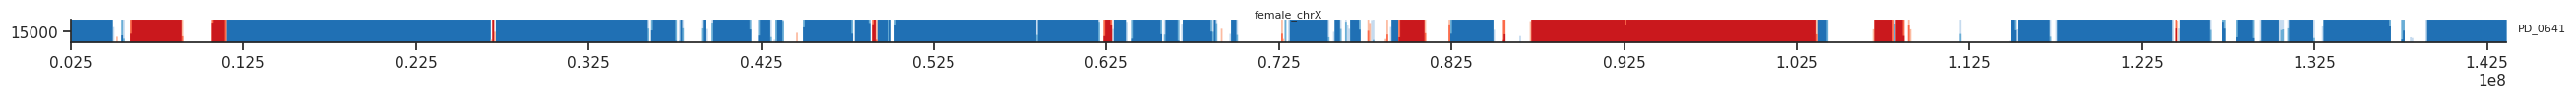

In [37]:
ind_test = window_df.loc[window_df.individual == "PD_0641"]
for c in window_df.chrom.unique():
    c_sub = ind_test.loc[(ind_test.chrom == c) & (ind_test.windows >= 2500000)]
    fig = horizonplot(c_sub, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

Investigation of autosomes

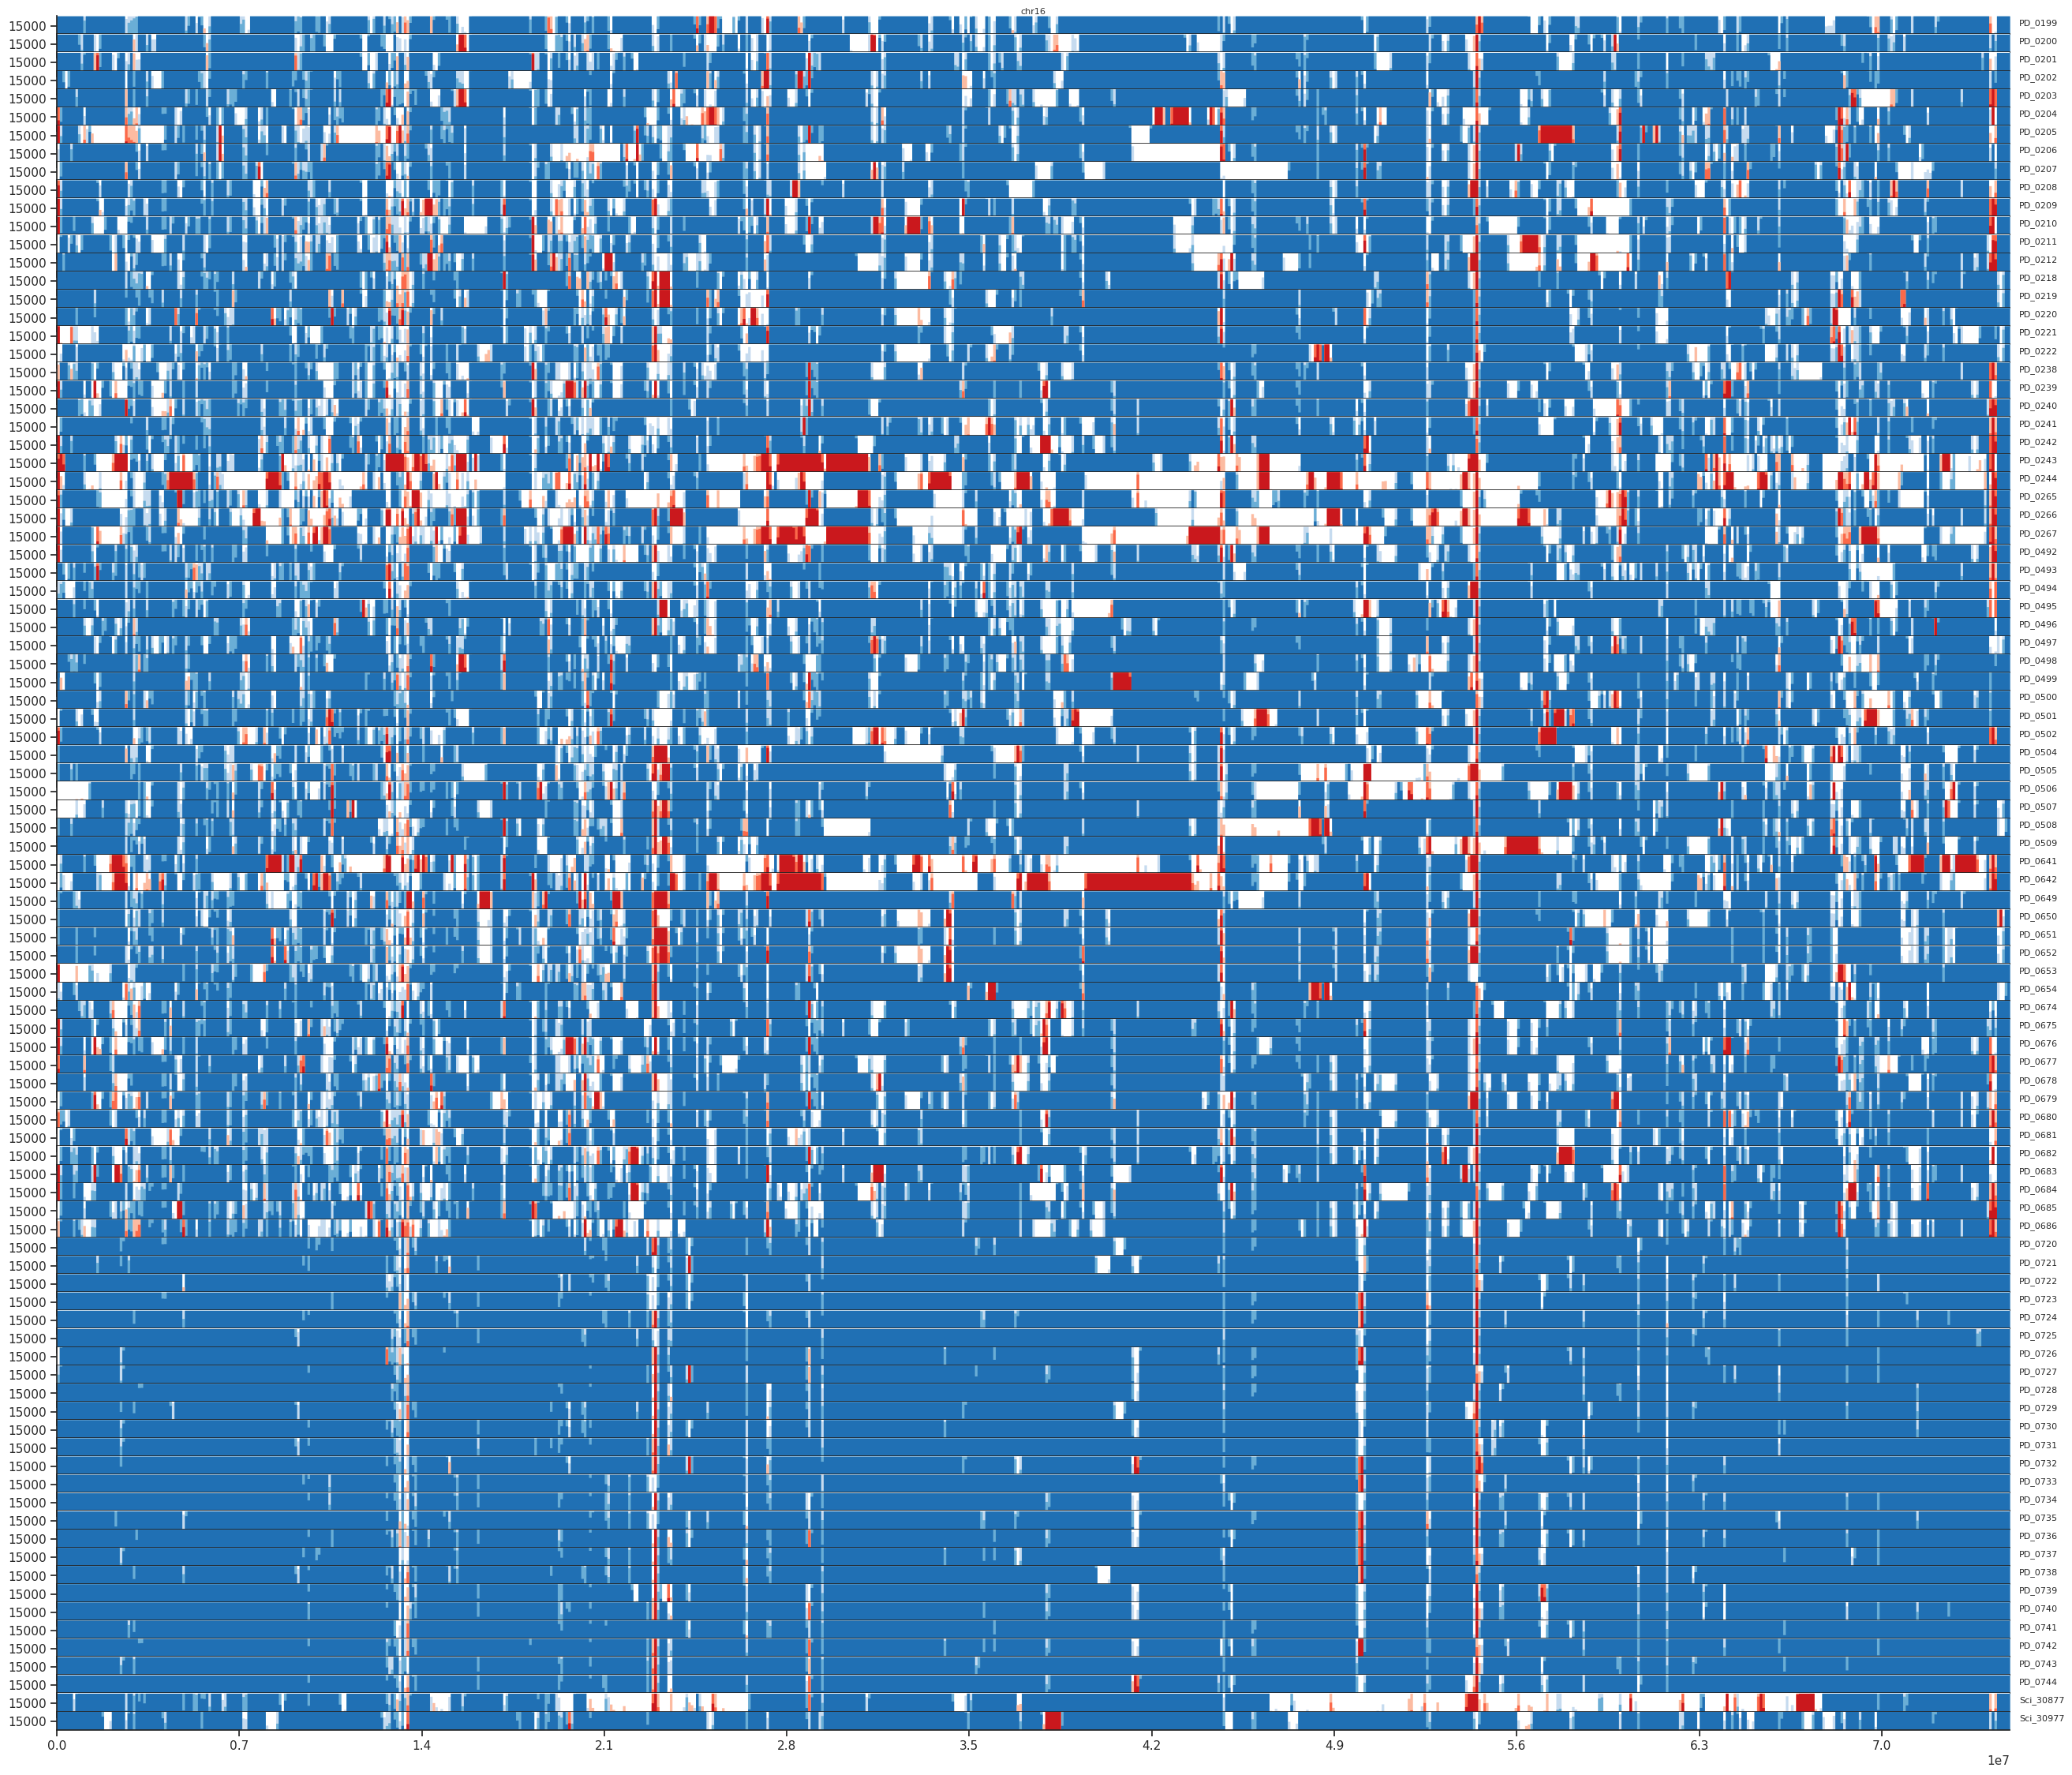

In [14]:
anubis = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "anubis"].PGDP_ID)]
chr16 = anubis.loc[anubis.chrom == "chr16"]
fig = horizonplot(chr16, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

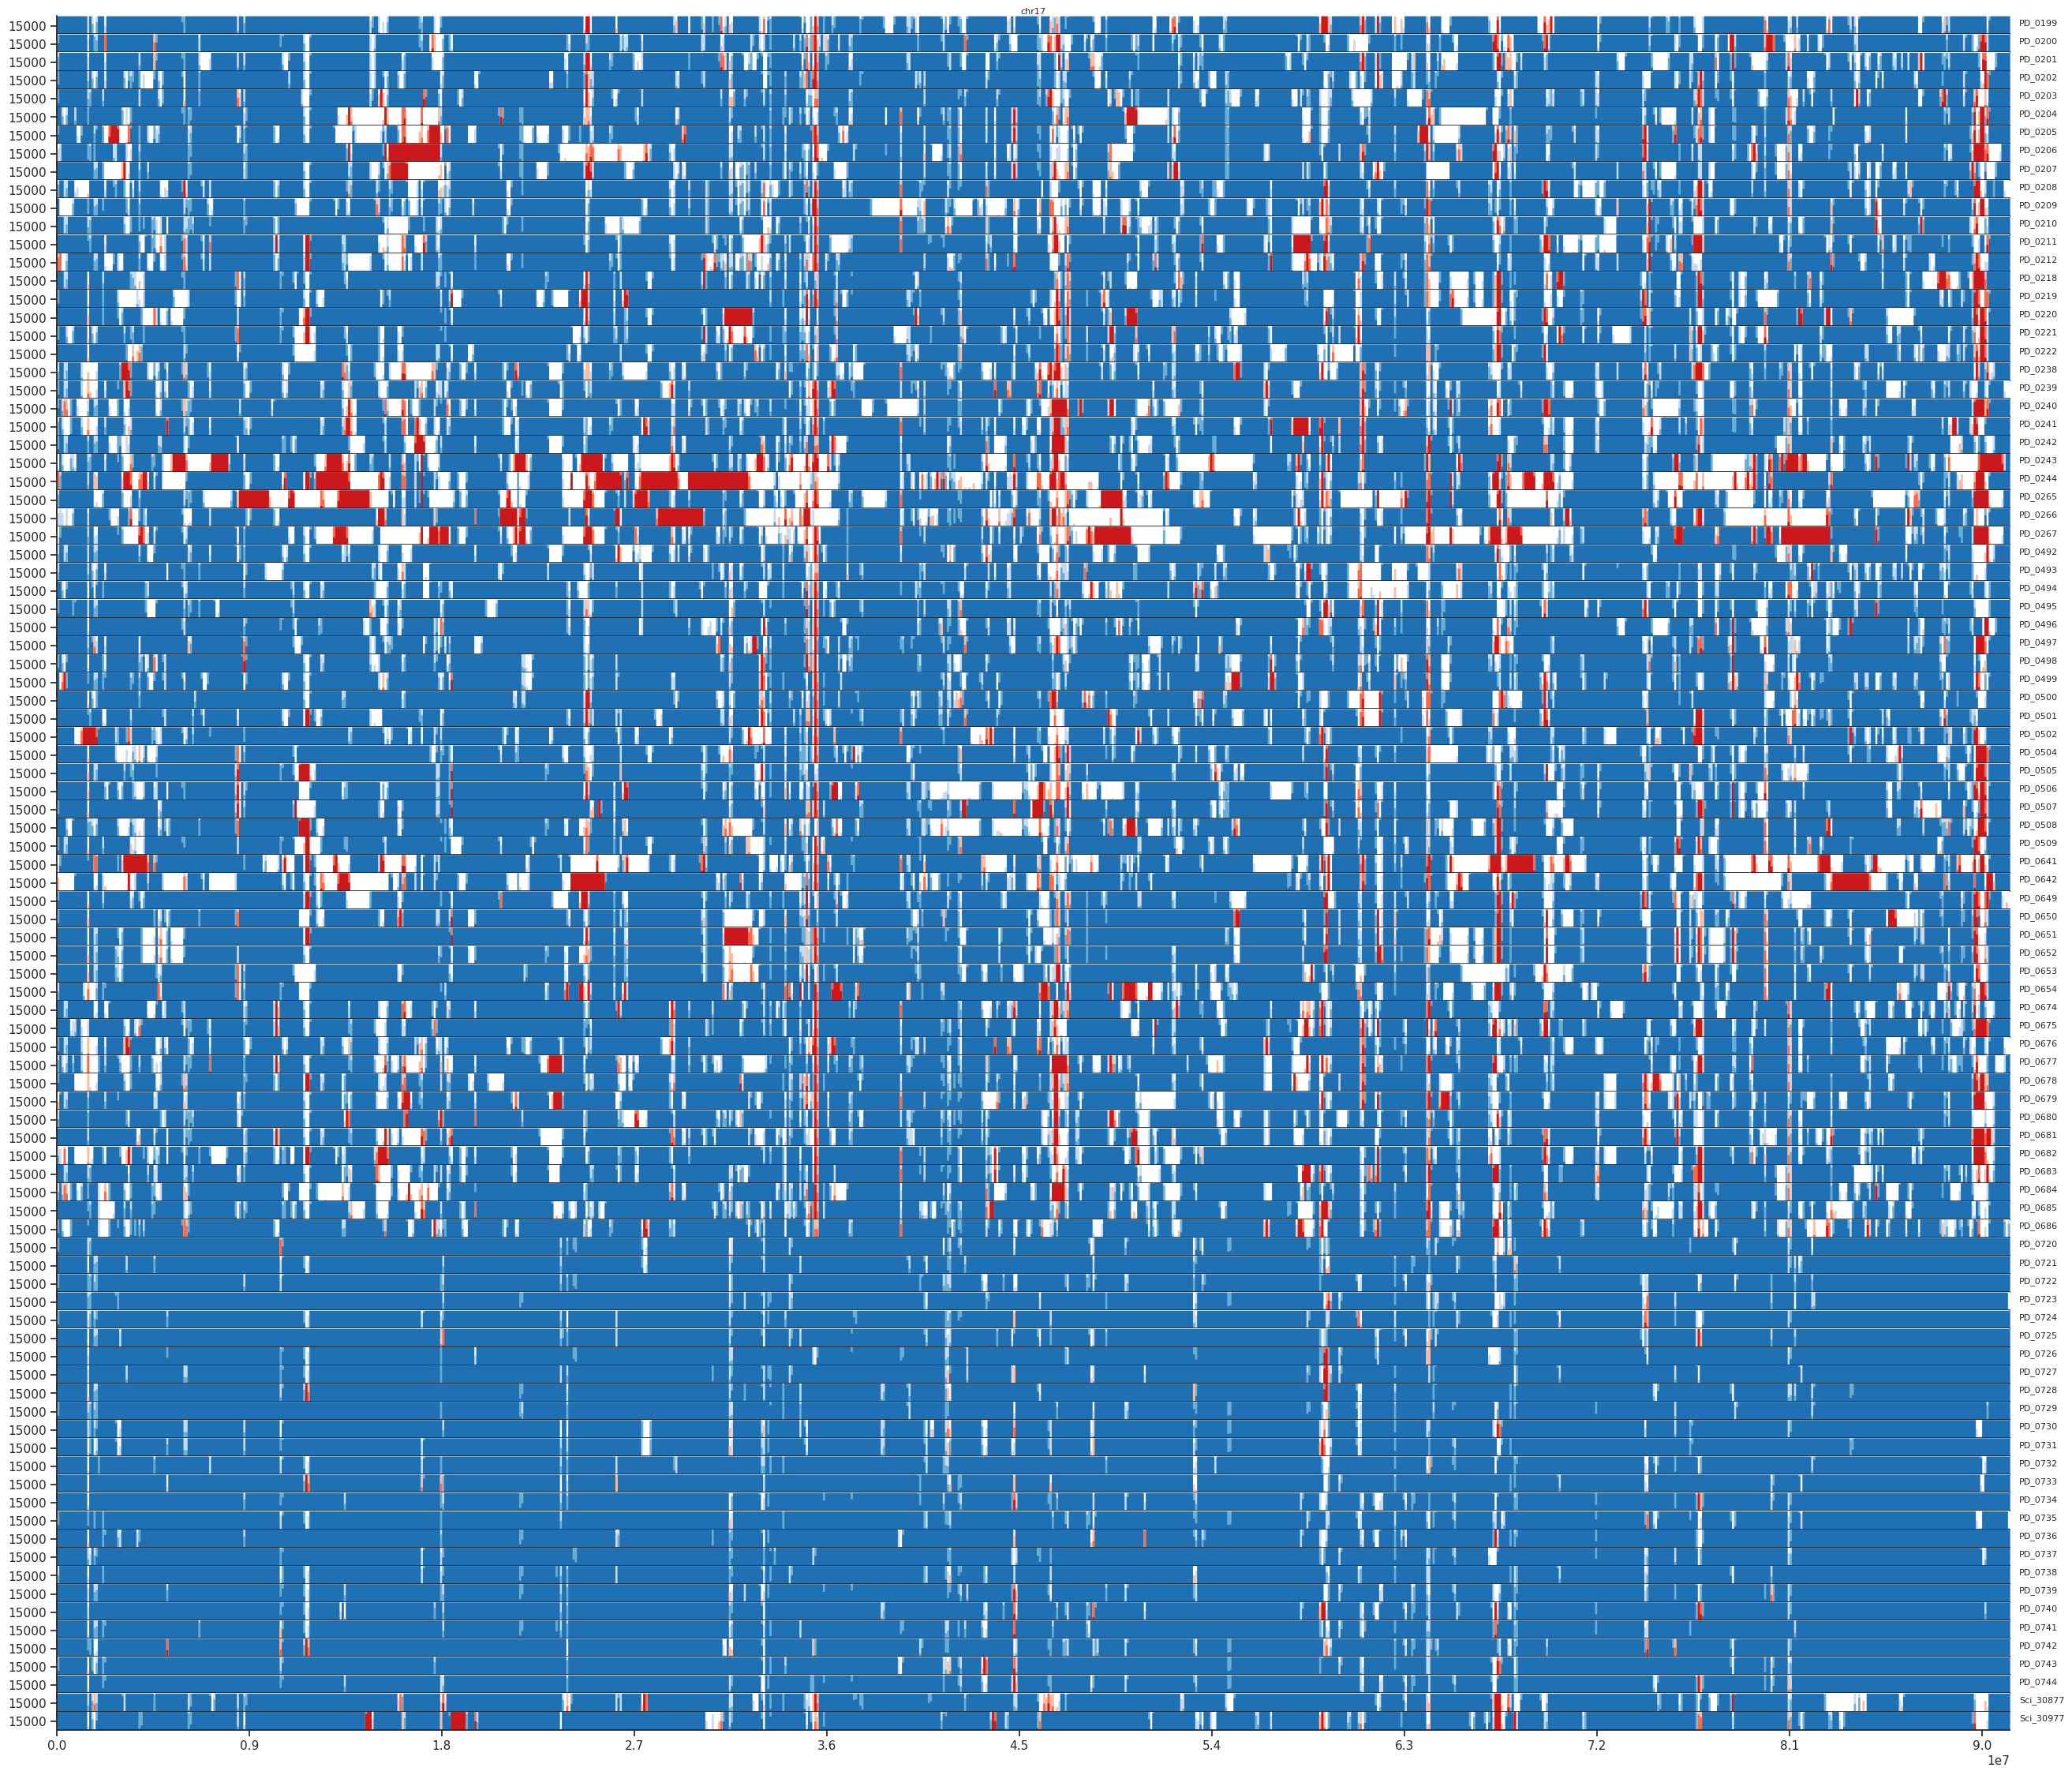

In [16]:
anubis = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "anubis"].PGDP_ID)]
chr17 = anubis.loc[anubis.chrom == "chr17"]
fig = horizonplot(chr17, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

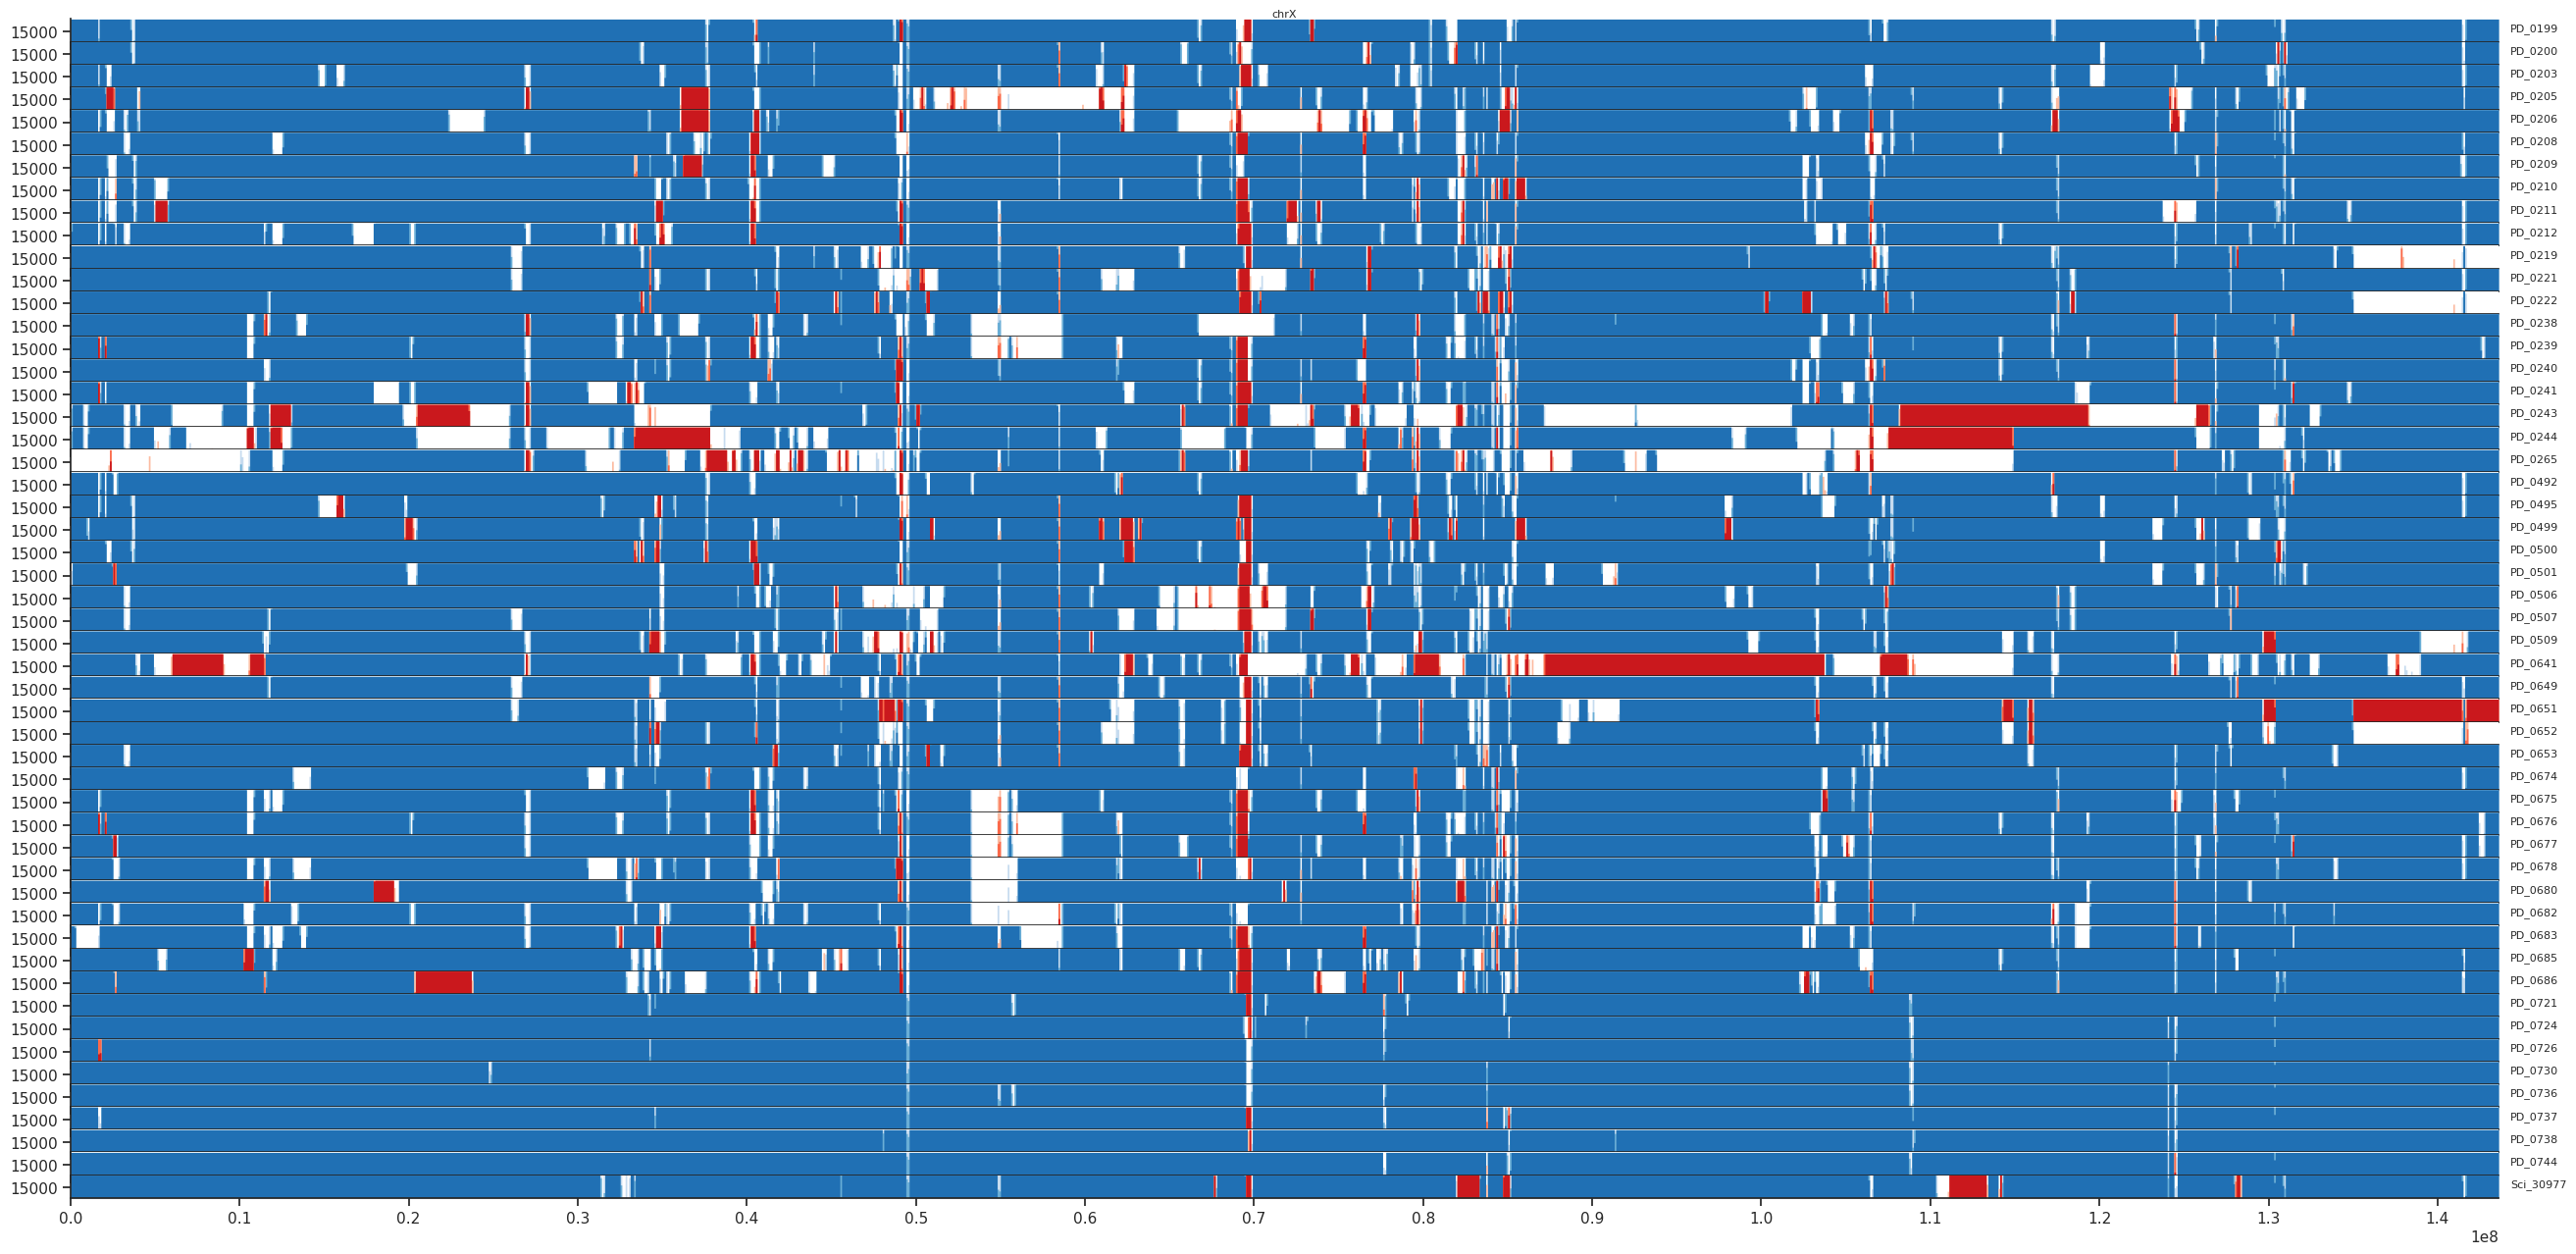

In [15]:
anubis = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "anubis"].PGDP_ID)]
chrX = anubis.loc[anubis.chrom == "chrX"]
fig = horizonplot(chrX, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

In [17]:
anubis = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "hamadryas"].PGDP_ID)]
chr17 = anubis.loc[anubis.chrom == "chr17"]
fig = horizonplot(chr17, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 0x0 with 0 Axes>